In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
import gzip
import random
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签win
plt.rcParams["font.family"] = 'Arial Unicode MS'  # mac
plt.rcParams['axes.unicode_minus'] = False  #用来正常显示负号
%matplotlib inline

In [2]:
types_train = {
    'id': np.dtype(int), 
    'click': np.dtype(int),       #是否点击,1表示被点击,0表示没被点击
    'hour': np.dtype(int),        #广告被展现的日期+时间
    'C1': np.dtype(int),          #匿名分类变量
    'banner_pos': np.dtype(int),  #广告位置
    'site_id': np.dtype(str),     #站点Id
    'site_domain': np.dtype(str),  #站点域名
    'site_category': np.dtype(str), #站点分类
    'app_id': np.dtype(str),        # appId 
    'app_domain': np.dtype(str),    # app域名
    'app_category': np.dtype(str),  # app分类
    'device_id': np.dtype(str),     #设备Id
    'device_ip': np.dtype(str),     #设备Ip
    'device_model': np.dtype(str),  #设备型号
    'device_type': np.dtype(int),   #设备型号
    'device_conn_type': np.dtype(int),
    'C14': np.dtype(int),   #匿名分类变量
    'C15': np.dtype(int),   #匿名分类变量
    'C16': np.dtype(int),   #匿名分类变量
    'C17': np.dtype(int),   #匿名分类变量
    'C18': np.dtype(int),   #匿名分类变量
    'C19': np.dtype(int),   #匿名分类变量
    'C20': np.dtype(int),   #匿名分类变量
    'C21':np.dtype(int)    #匿名分类变量
}

In [5]:
n = 40428967  #数据集中的记录总数
sample_size = 1000000
skip_values = sorted(random.sample(range(1, n), n - sample_size))
parse_date = lambda val: pd.datetime.strptime(val, '%y%m%d%H')

# 数据集较大时，使用python解压
with gzip.open('train.gz') as f:
    train = pd.read_csv(f,
                        parse_dates=['hour'],
                        date_parser=parse_date,
                        dtype=types_train,
                        skiprows=skip_values)
print(len(train))
train.head()

1000000


,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,10003539039235338011,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15699,320,50,1722,0,35,100084,79
1,10011650513707909570,0,2014-10-21,1005,0,85f751fd,c4e18dd6,50e219e0,febd1138,82e27996,...,1,0,21611,320,50,2480,3,297,100111,61
2,10019174283089529533,0,2014-10-21,1005,0,bb4524e7,d733bbc3,28905ebd,ecad2386,7801e8d9,...,1,0,9438,320,50,898,3,427,100003,61
3,10020605367282200605,0,2014-10-21,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,...,1,0,20359,216,36,2333,0,39,-1,157
4,10022778968214273379,0,2014-10-21,1005,1,93de26ae,7d05db75,335d28a8,ecad2386,7801e8d9,...,1,0,18993,320,50,2161,0,35,-1,157


0    830672
1    169328
Name: click, dtype: int64

0    0.830672
1    0.169328
Name: click, dtype: float64


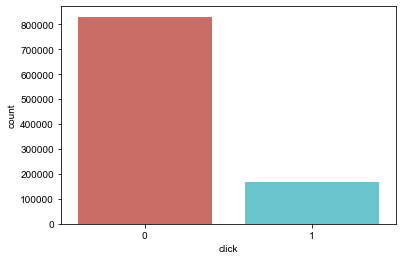

In [8]:
print(train['click'].value_counts())
print()
print(train['click'].value_counts() / len(train))
sns.countplot(x='click', data=train, palette='hls')
plt.show()

In [9]:
train.hour.describe()

count                 1000000
unique                    240
top       2014-10-22 09:00:00
freq                    11284
first     2014-10-21 00:00:00
last      2014-10-30 23:00:00
Name: hour, dtype: object

Text(0.5, 1.0, '时间和点击量')

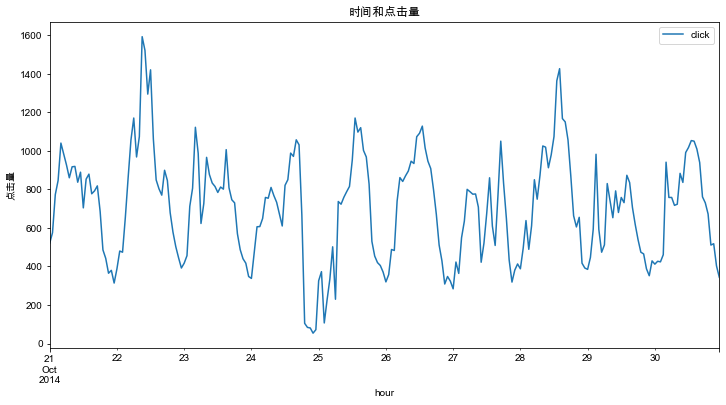

In [10]:
# 连续几天的点击量
train.groupby('hour').agg({'click': 'sum'}).plot(figsize=(12, 6))
plt.ylabel('点击量')
plt.title('时间和点击量')

In [11]:
# 创建新的列
train['time'] = train.hour.apply(lambda x: x.hour)
train.sample(5)

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,time
937215,6910871083309819475,0,2014-10-30 09:00:00,1005,0,9ee9dd00,759d1c56,f028772b,ecad2386,7801e8d9,...,0,17239,320,50,1973,3,39,-1,23,9
213230,8666917622876233984,0,2014-10-22 17:00:00,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,2,15708,320,50,1722,0,35,-1,79,17
917060,1698807084944363249,0,2014-10-30 05:00:00,1005,0,85f751fd,c4e18dd6,50e219e0,e8691eac,2347f47a,...,0,23804,320,50,2726,3,803,100148,229,5
699328,784459489179413696,0,2014-10-28 07:00:00,1005,1,57ef2c87,bd6d812f,f028772b,ecad2386,7801e8d9,...,0,19771,320,50,2227,0,935,100081,48,7
7405,13576680956187120325,0,2014-10-21 02:00:00,1005,0,85f751fd,c4e18dd6,50e219e0,39947756,2347f47a,...,2,21647,320,50,2487,1,547,-1,51,2


Text(0.5, 1.0, '时间和点击量')

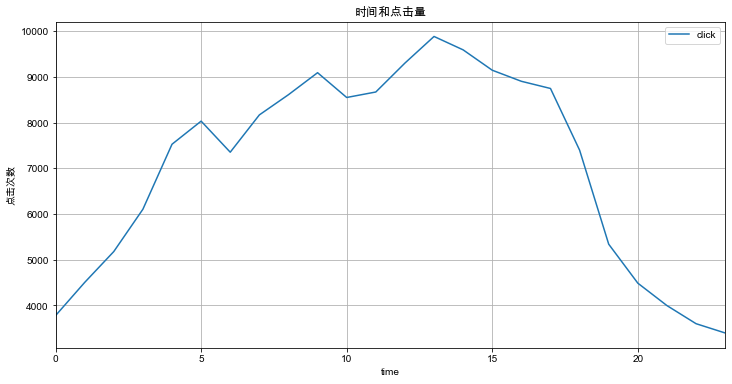

In [12]:
# 每个小时的点击量
train.groupby('time').agg({'click': 'sum'}).plot(figsize=(12, 6), grid=True)
plt.ylabel('点击次数')
plt.title('时间和点击量')

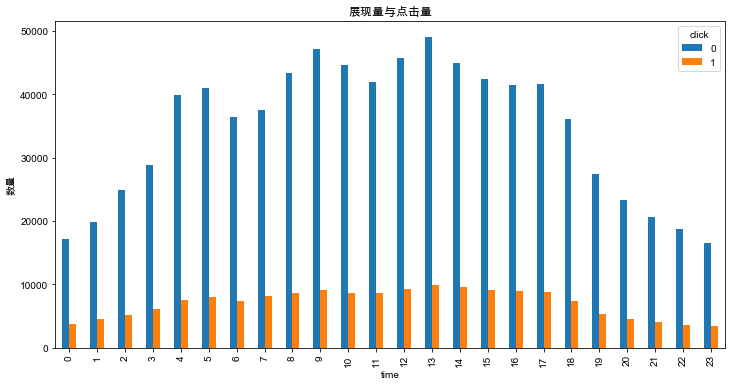

In [13]:
# 展现量与点击量的对比
train.groupby(['time', 'click']).size().unstack().plot(kind='bar',
                                                       figsize=(12, 6))
plt.ylabel('数量')
plt.title('展现量与点击量')

In [14]:
# 计算CTR
df_click = train[train['click'] == 1]
df_hour = train[['time', 'click']].groupby(['time']).count().reset_index()
df_hour = df_hour.rename(columns={'click': 'impressions'})
df_hour['clicks'] = df_click[['time', 'click'
                              ]].groupby(['time'
                                          ]).count().reset_index()['click']
df_hour['CTR'] = df_hour['clicks'] / df_hour['impressions'] * 100
df_hour.head()

,time,impressions,clicks,CTR
0,0,20898,3779,18.083070
1,1,24358,4504,18.490845
2,2,30079,5179,17.217993
3,3,34950,6104,17.464950
4,4,47378,7525,15.882899


Text(0.5, 1.0, '点击率的时间分布')

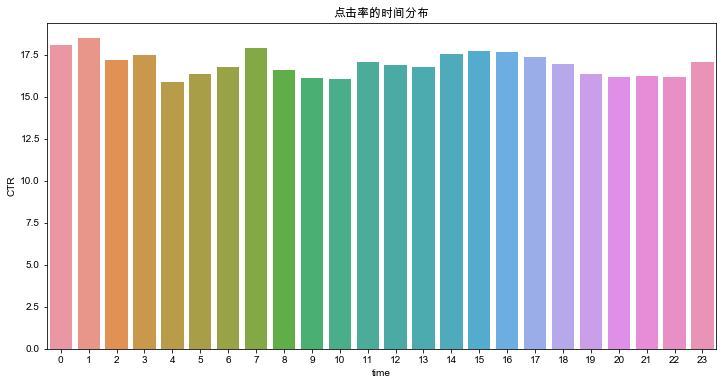

In [15]:
# 点击率的时间分布
plt.figure(figsize=(12, 6))
sns.barplot(y='CTR', x='time', data=df_hour)
plt.title('点击率的时间分布')

/Users/seven/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `weekday_name` is deprecated and will be removed in a future version. Use `day_name` instead
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, '星期的点击量')

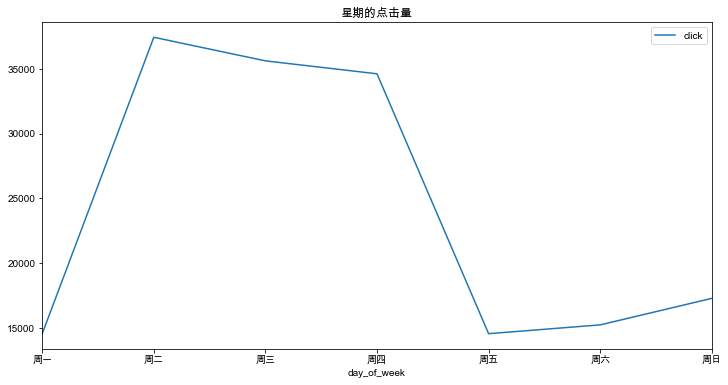

In [16]:
# 星期的点击率
train['day_of_week'] = train['hour'].apply(lambda val: val.weekday_name)
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
train.groupby('day_of_week').agg({'click': 'sum'}).reindex(cats).plot(figsize=(12, 6))
ticks = list(range(0, 7, 1))
labels = "周一 周二 周三 周四 周五 周六 周日".split()
plt.xticks(ticks, labels)
plt.title('星期的点击量')

Text(0.5, 1.0, '星期的展现量和点击量分布')

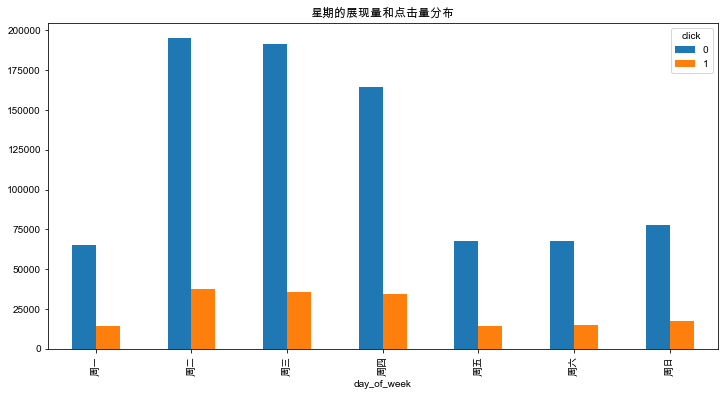

In [17]:
# 每星期的展现和点击
train.groupby(['day_of_week', 'click']).size().unstack().reindex(cats).plot(kind='bar',
                                                      title="Day of the Week",
                                                      figsize=(12, 6))
ticks = list(range(0, 7, 1))
labels = "周一 周二 周三 周四 周五 周六 周日".split()
plt.xticks(ticks, labels)
plt.title('星期的展现量和点击量分布')

Text(0.5, 1.0, '星期的点击率')

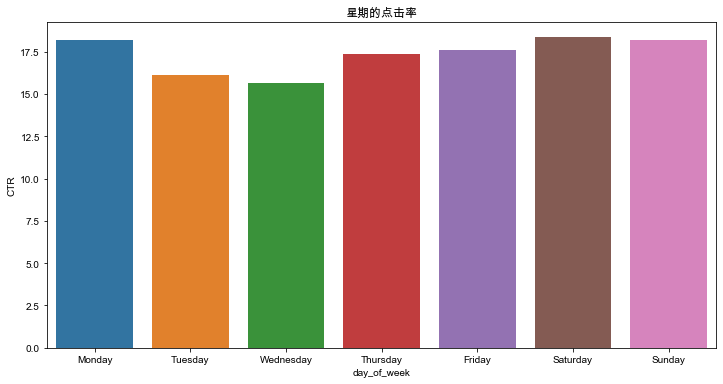

In [18]:
# 星期中每天的点击率
df_click = train[train['click'] == 1]
df_dayofweek = train[['day_of_week',
                      'click']].groupby(['day_of_week']).count().reset_index()
df_dayofweek = df_dayofweek.rename(columns={'click': 'impressions'})
df_dayofweek['clicks'] = df_click[['day_of_week', 'click']].groupby(
    ['day_of_week']).count().reset_index()['click']
df_dayofweek[
    'CTR'] = df_dayofweek['clicks'] / df_dayofweek['impressions'] * 100

plt.figure(figsize=(12, 6))
# sns.set(style="whitegrid")
sns.barplot(y='CTR',
            x='day_of_week',
            data=df_dayofweek,
            order=[
                'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday',
                'Saturday', 'Sunday'
            ])
plt.title('星期的点击率')

In [19]:
# 查看未知变量
print(train.C1.value_counts() / len(train))

1005    0.919132
1002    0.054729
1010    0.022071
1012    0.002793
1007    0.000892
1001    0.000252
1008    0.000131
Name: C1, dtype: float64


In [20]:
C1_values = train.C1.unique()
C1_values.sort()
ctr_avg_list=[]
for i in C1_values:
    ctr_avg=train.loc[np.where((train.C1 == i))].click.mean()
    ctr_avg_list.append(ctr_avg)
    print(" C1 value: {},  点击率: {}".format(i,ctr_avg))

 C1 value: 1001,  点击率: 0.03968253968253968
 C1 value: 1002,  点击率: 0.21239196769537175
 C1 value: 1005,  点击率: 0.1687755404011611
 C1 value: 1007,  点击率: 0.03699551569506727
 C1 value: 1008,  点击率: 0.13740458015267176
 C1 value: 1010,  点击率: 0.0927461374654524
 C1 value: 1012,  点击率: 0.16791979949874686


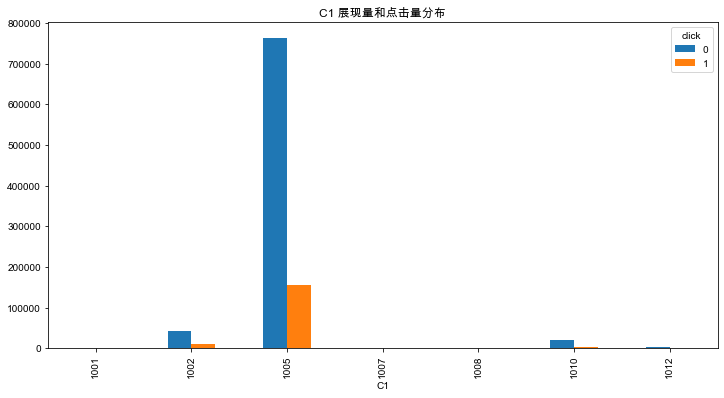

In [21]:
train.groupby(['C1', 'click']).size().unstack().plot(kind='bar',
                                                     figsize=(12, 6),
                                                     title='C1 展现量和点击量分布')

Text(0.5, 1.0, 'C1的点击率分布')

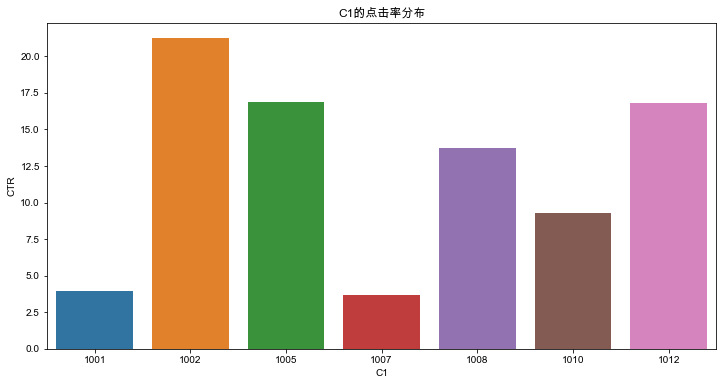

In [22]:
df_c1 = train[['C1', 'click']].groupby(['C1']).count().reset_index()
df_c1 = df_c1.rename(columns={'click': 'impressions'})
df_c1['clicks'] = df_click[['C1', 'click'
                            ]].groupby(['C1']).count().reset_index()['click']
df_c1['CTR'] = df_c1['clicks'] / df_c1['impressions'] * 100

plt.figure(figsize=(12, 6))
sns.barplot(y='CTR', x='C1', data=df_c1)
plt.title('C1的点击率分布')

In [23]:
print(train.banner_pos.value_counts() / len(train))

0    0.720397
1    0.277864
7    0.001021
2    0.000328
4    0.000204
5    0.000131
3    0.000055
Name: banner_pos, dtype: float64


In [24]:
# 广告位置的点击率分布
banner_pos = train.banner_pos.unique()
banner_pos.sort()
ctr_avg_list = []
for i in banner_pos:
    ctr_avg = train.loc[np.where((train.banner_pos == i))].click.mean()
    ctr_avg_list.append(ctr_avg)
    print(" banner 位置: {},  点击率: {}".format(i, ctr_avg))

 banner 位置: 0,  点击率: 0.164092854356695
 banner 位置: 1,  点击率: 0.1824849566694498
 banner 位置: 2,  点击率: 0.11585365853658537
 banner 位置: 3,  点击率: 0.18181818181818182
 banner 位置: 4,  点击率: 0.16666666666666666
 banner 位置: 5,  点击率: 0.13740458015267176
 banner 位置: 7,  点击率: 0.3036238981390793


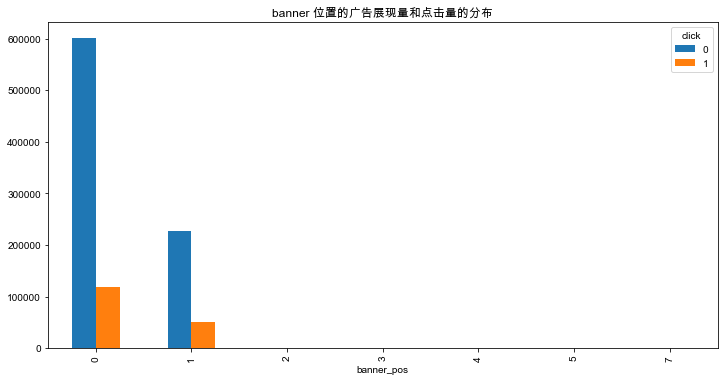

In [25]:
train.groupby(['banner_pos',
               'click']).size().unstack().plot(kind='bar',
                                               figsize=(12, 6),
                                               title='banner 位置的广告展现量和点击量的分布')

Text(0.5, 1.0, 'banner 位置的点击率的分布')

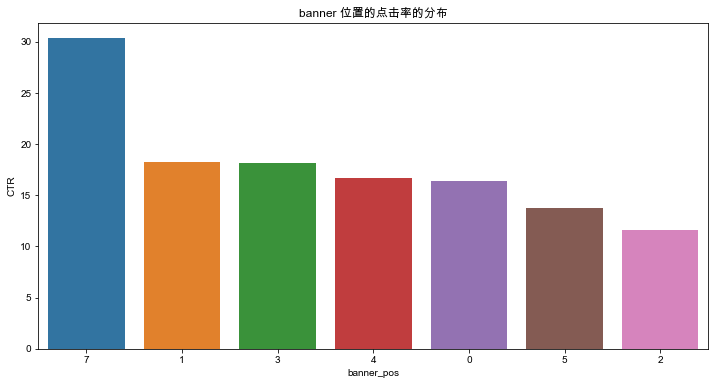

In [26]:
df_banner = train[['banner_pos',
                   'click']].groupby(['banner_pos']).count().reset_index()
df_banner = df_banner.rename(columns={'click': 'impressions'})
df_banner['clicks'] = df_click[['banner_pos', 'click'
                                ]].groupby(['banner_pos'
                                            ]).count().reset_index()['click']
df_banner['CTR'] = df_banner['clicks'] / df_banner['impressions'] * 100
sort_banners = df_banner.sort_values(by='CTR',
                                     ascending=False)['banner_pos'].tolist()
plt.figure(figsize=(12, 6))
sns.barplot(y='CTR', x='banner_pos', data=df_banner, order=sort_banners)
plt.title('banner 位置的点击率的分布')

In [27]:
print((train.device_type.value_counts() / len(train)))

1    0.923198
0    0.054729
4    0.018911
5    0.003160
2    0.000002
Name: device_type, dtype: float64


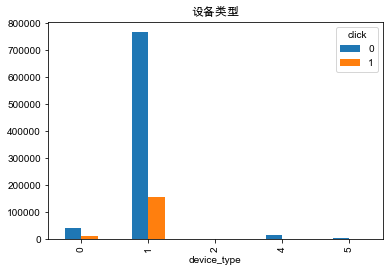

In [28]:
# 设备类型
train[['device_type',
       'click']].groupby(['device_type',
                          'click']).size().unstack().plot(kind='bar',
                                                          title='设备类型')

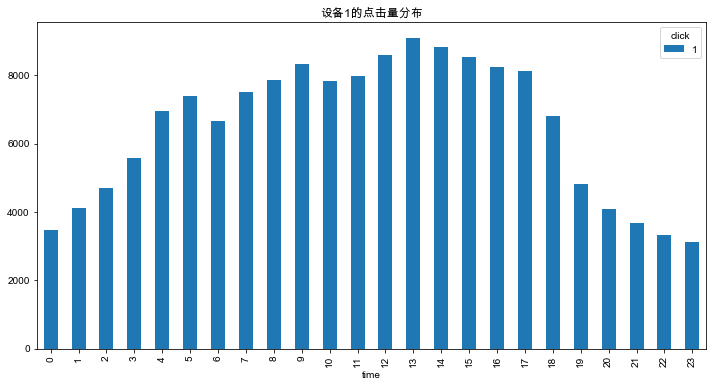

In [29]:
df_click[df_click['device_type']==1].groupby(['time', 'click'])\
                                     .size().unstack()\
                                     .plot(kind='bar', title="设备1的点击量分布", figsize=(12,6))

In [30]:
device_type_click = df_click.groupby('device_type').agg({
    'click': 'sum'
}).reset_index()
device_type_impression = train.groupby('device_type').agg({
    'click': 'count'
}).reset_index().rename(columns={'click': 'impressions'})
merged_device_type = pd.merge(left=device_type_click,
                              right=device_type_impression,
                              how='inner',
                              on='device_type')

merged_device_type['CTR'] = merged_device_type['click'] / merged_device_type[
    'impressions'] * 100

merged_device_type

,device_type,click,impressions,CTR
0,0,11624,54729,21.239197
1,1,155657,923198,16.860630
2,4,1763,18911,9.322616
3,5,284,3160,8.987342


In [31]:
print("app_id的唯一值有 {} 个".format(train.app_id.nunique()))
print("app_domain的唯一值有 {} 个".format(train.app_domain.nunique()))
print("app_category的唯一值有 {} 个".format(train.app_category.nunique()))

app_id的唯一值有 3156 个
app_domain的唯一值有 211 个
app_category的唯一值有 27 个


In [32]:
print((train.app_category.value_counts() / len(train)))

07d7df22    0.647338
0f2161f8    0.236564
cef3e649    0.042752
8ded1f7a    0.036355
f95efa07    0.028079
d1327cf5    0.002980
09481d60    0.001354
dc97ec06    0.001346
75d80bbe    0.000991
4ce2e9fc    0.000558
fc6fa53d    0.000558
879c24eb    0.000311
a3c42688    0.000283
4681bb9d    0.000163
0f9a328c    0.000138
a86a3e89    0.000058
2281a340    0.000055
8df2e842    0.000044
79f0b860    0.000026
18b1e0be    0.000010
0bfbc358    0.000009
a7fd01ec    0.000008
7113d72a    0.000007
2fc4f2aa    0.000006
5326cf99    0.000005
52de74cf    0.000001
6fea3693    0.000001
Name: app_category, dtype: float64


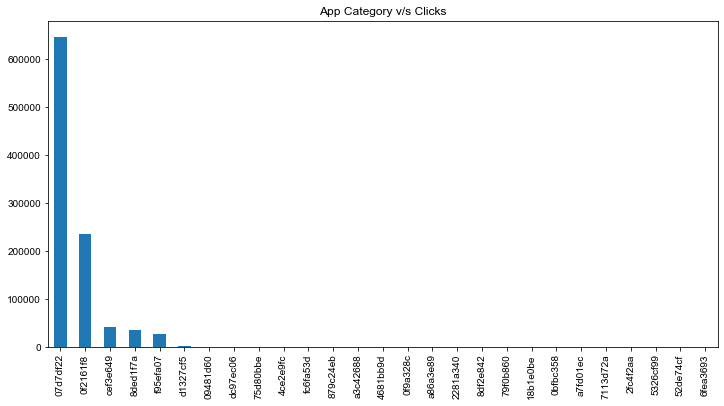

In [33]:
train['app_category'].value_counts().plot(kind='bar',
                                          title='App Category v/s Clicks',
                                          figsize=(12, 6))

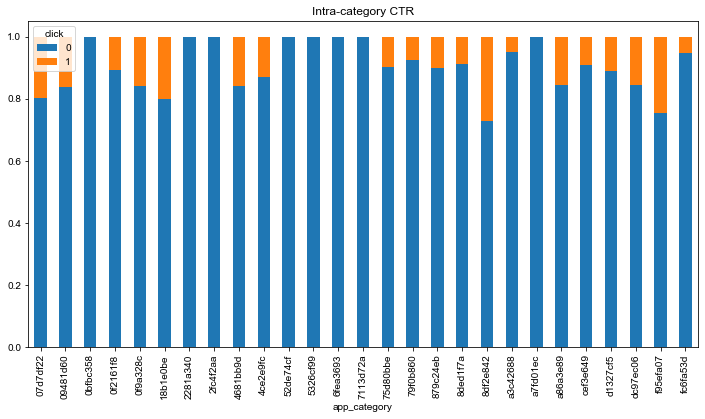

In [34]:
train_app_category = train.groupby(['app_category', 'click']).size().unstack()
train_app_category.div(train_app_category.sum(axis=1),
                       axis=0).plot(kind='bar',
                                    stacked=True,
                                    title="Intra-category CTR",
                                    figsize=(12, 6))

建模

In [35]:
# 将obj转换为int
# hash：用于返回一个对象的哈希值
def convert_obj_to_int(self):

    object_list_columns = self.columns
    object_list_dtypes = self.dtypes
    new_col_suffix = '_int'
    for index in range(0, len(object_list_columns)):
        if object_list_dtypes[index] == object:
            self[object_list_columns[index] + new_col_suffix] = self[
                object_list_columns[index]].map(lambda x: hash(x))
            self.drop([object_list_columns[index]], inplace=True, axis=1)
    return self


train = convert_obj_to_int(train)
train.head()

,id,click,hour,C1,banner_pos,device_type,device_conn_type,C14,C15,C16,...,site_id_int,site_domain_int,site_category_int,app_id_int,app_domain_int,app_category_int,device_id_int,device_ip_int,device_model_int,day_of_week_int
0,10003539039235338011,0,2014-10-21,1005,0,1,0,15699,320,50,...,-3976607580781852223,7364249105369296360,3216496860130427497,-3647641334236379640,8588734229617674659,3623973394793068134,5973486633720506328,-6633783976926109534,5798681780403498168,-2997558397451300639
1,10011650513707909570,0,2014-10-21,1005,0,1,0,21611,320,50,...,3625170385561812549,2044844330541558179,1945425056675507354,6089913649826004327,118380000027699491,6451865886099906794,5973486633720506328,8969620697133560012,2209142849494091729,-2997558397451300639
2,10019174283089529533,0,2014-10-21,1005,0,1,0,9438,320,50,...,4570658853535044790,-2213153036815469423,3216496860130427497,-3647641334236379640,8588734229617674659,3623973394793068134,5973486633720506328,-3920702252082756674,7960912283072746920,-2997558397451300639
3,10020605367282200605,0,2014-10-21,1005,1,1,0,20359,216,36,...,3972804766066130760,418512646130493063,-2236969705169950808,-3647641334236379640,8588734229617674659,3623973394793068134,5973486633720506328,-4975713955819982432,9150200671181662975,-2997558397451300639
4,10022778968214273379,0,2014-10-21,1005,1,1,0,18993,320,50,...,6380572753619320498,-3319282642211672362,1954528241914201124,-3647641334236379640,8588734229617674659,3623973394793068134,5973486633720506328,-1767076948413531542,-1016721831278198229,-2997558397451300639


In [36]:
train.drop('hour', axis=1, inplace=True)
train.drop('id', axis=1, inplace=True)

X_train = train.loc[:, train.columns != 'click']
y_target = train.click.values

In [37]:
def run_default_test(train, test, features, target, random_state=0):
    eta = 0.1
    max_depth = 5
    subsample = 0.8
    colsample_bytree = 0.8
    params = {
        # 而分类
        "objective": "binary:logistic",
        # 树模型
        "booster": "gbtree",
        # log损失
        "eval_metric": "logloss",
        # 学习率
        "eta": eta,
        # 最大树深度
        "max_depth": max_depth,
        # 训练集占比
        "subsample": subsample,
        # 随机采样比例
        "colsample_bytree": colsample_bytree,
        # 信息输出
        "silent": 1,
        "seed": random_state
    }
    num_boost_round = 260
    early_stopping_rounds = 20
    test_size = 0.2

    X_train, X_valid = train_test_split(train,
                                        test_size=test_size,
                                        random_state=random_state)
    y_train = X_train[target]
    y_valid = X_valid[target]
    dtrain = xgb.DMatrix(X_train[features], y_train)
    dvalid = xgb.DMatrix(X_valid[features], y_valid)
    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
    gbm = xgb.train(params,
                    dtrain,
                    num_boost_round,
                    evals=watchlist,
                    early_stopping_rounds=early_stopping_rounds,
                    verbose_eval=True)

In [38]:
features = [
    'C1', 'banner_pos', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16',
    'C17', 'C18', 'C19', 'C20', 'C21', 'time', 'site_id_int',
    'site_domain_int', 'site_category_int', 'app_id_int', 'app_domain_int',
    'app_category_int', 'device_id_int', 'device_ip_int', 'device_model_int',
    'day_of_week_int'
]
run_default_test(train, y_target, features, 'click')

/Users/seven/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/seven/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	train-logloss:0.648833	eval-logloss:0.648601
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 20 rounds.
[1]	train-logloss:0.6126	eval-logloss:0.612338
[2]	train-logloss:0.582466	eval-logloss:0.582136
[3]	train-logloss:0.557667	eval-logloss:0.557161
[4]	train-logloss:0.536566	eval-logloss:0.53606
[5]	train-logloss:0.51939	eval-logloss:0.518741
[6]	train-logloss:0.504379	eval-logloss:0.503619
[7]	train-logloss:0.49166	eval-logloss:0.490915
[8]	train-logloss:0.481139	eval-logloss:0.480237
[9]	train-logloss:0.472043	eval-logloss:0.471097
[10]	train-logloss:0.464543	eval-logloss:0.463548
[11]	train-logloss:0.458026	eval-logloss:0.45693
[12]	train-logloss:0.452323	eval-logloss:0.451208
[13]	train-logloss:0.447313	eval-logloss:0.446206
[14]	train-logloss:0.443162	eval-logloss:0.441974
[15]	train-logloss:0.439557	eval-logloss:0.438399
[16]	train-logloss:0.43649	eval-logloss:0.435267
[17]	train-logloss

[161]	train-logloss:0.40298	eval-logloss:0.402395
[162]	train-logloss:0.402928	eval-logloss:0.402352
[163]	train-logloss:0.402868	eval-logloss:0.402301
[164]	train-logloss:0.40281	eval-logloss:0.402263
[165]	train-logloss:0.402745	eval-logloss:0.402215
[166]	train-logloss:0.402704	eval-logloss:0.402183
[167]	train-logloss:0.402665	eval-logloss:0.402152
[168]	train-logloss:0.402633	eval-logloss:0.40214
[169]	train-logloss:0.402611	eval-logloss:0.402126
[170]	train-logloss:0.402568	eval-logloss:0.402097
[171]	train-logloss:0.40254	eval-logloss:0.402085
[172]	train-logloss:0.402459	eval-logloss:0.40201
[173]	train-logloss:0.40242	eval-logloss:0.40199
[174]	train-logloss:0.402386	eval-logloss:0.401965
[175]	train-logloss:0.402328	eval-logloss:0.401921
[176]	train-logloss:0.402303	eval-logloss:0.401912
[177]	train-logloss:0.402214	eval-logloss:0.401837
[178]	train-logloss:0.402184	eval-logloss:0.401813
[179]	train-logloss:0.402125	eval-logloss:0.401756
[180]	train-logloss:0.402088	eval-logl